In [8]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from math import log2
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import warnings
import csv
import os
CLASS = "CLASS"
df = pd.read_csv("dataset.csv")
warnings.simplefilter('ignore')

<Axes: xlabel='Revenue'>

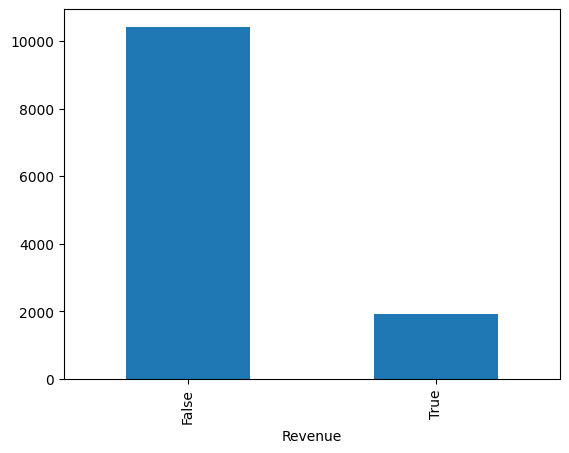

In [7]:
value_counts = df['Revenue'].value_counts()
value_counts.plot(kind='bar')

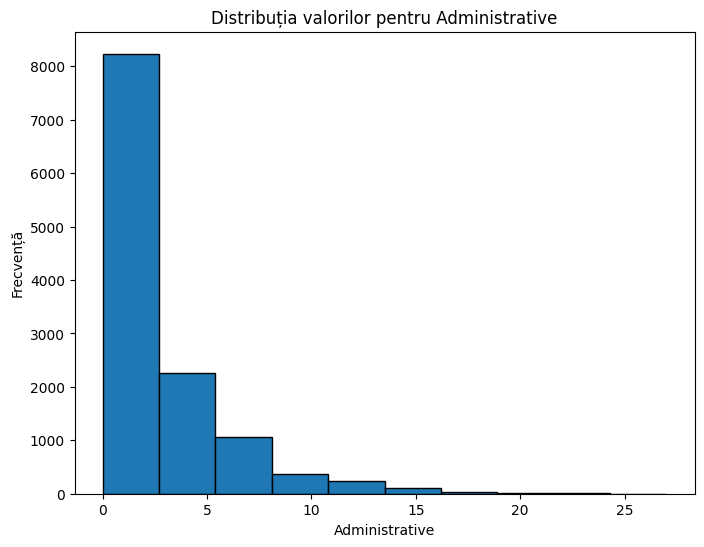

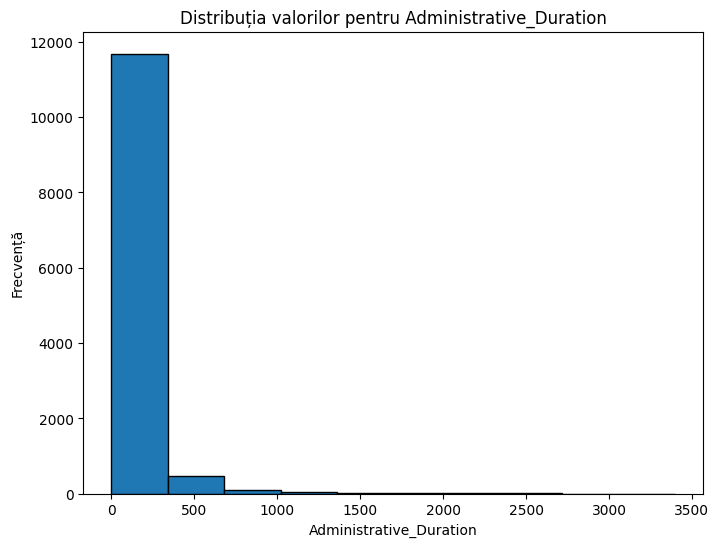

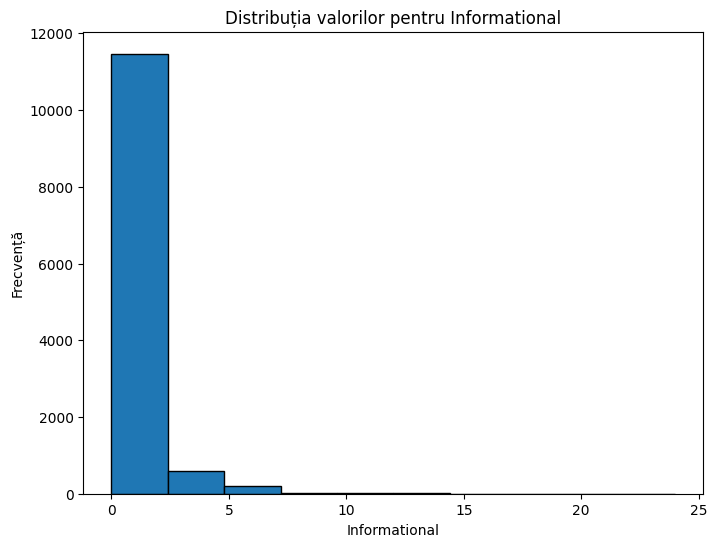

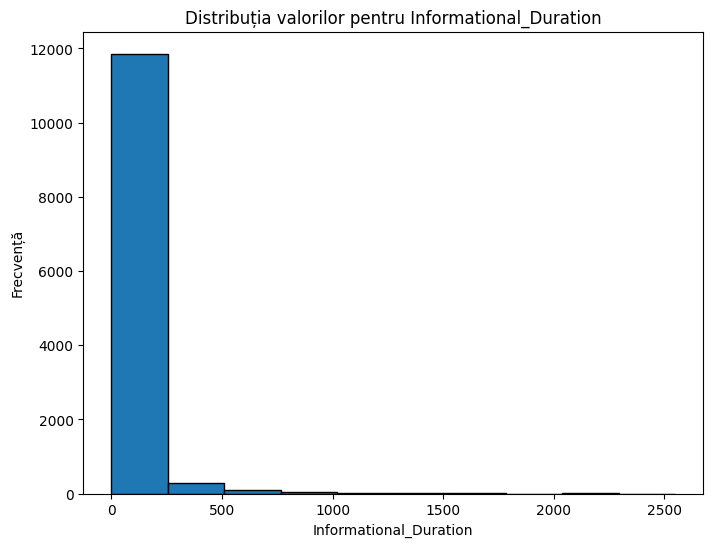

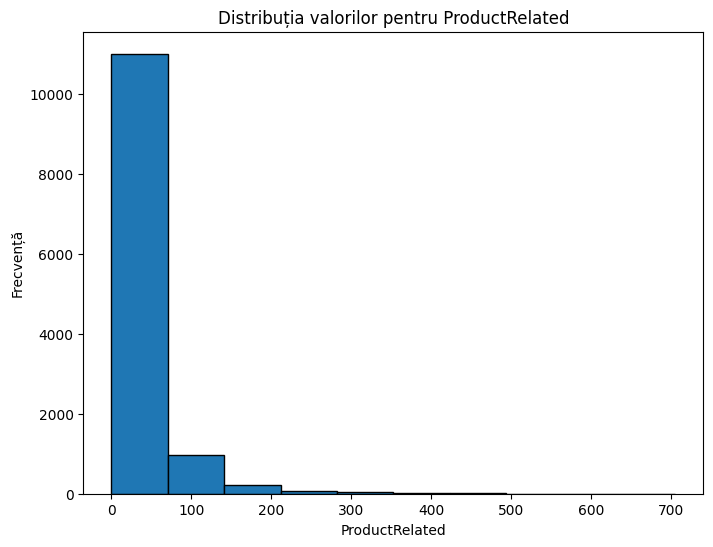

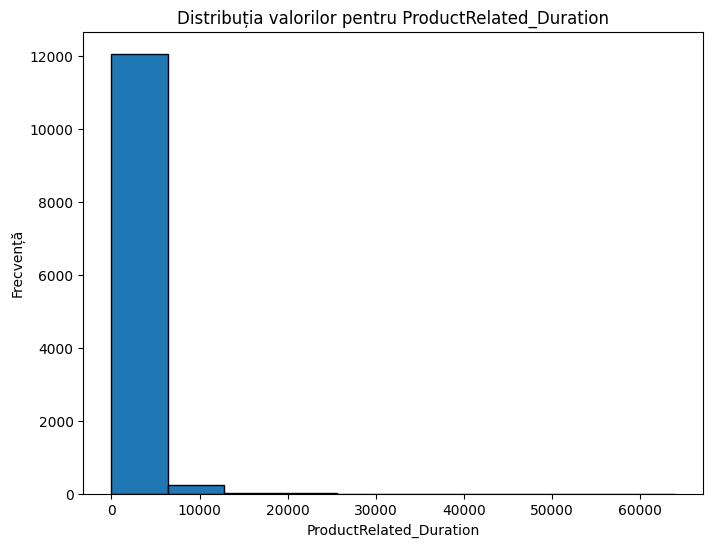

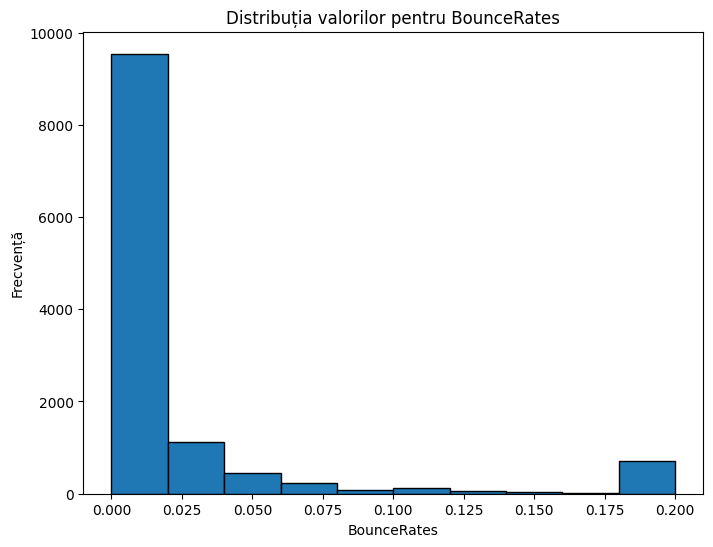

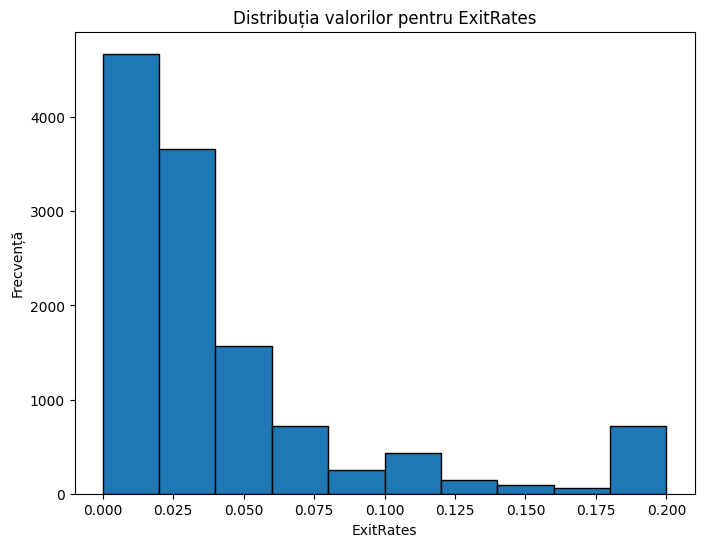

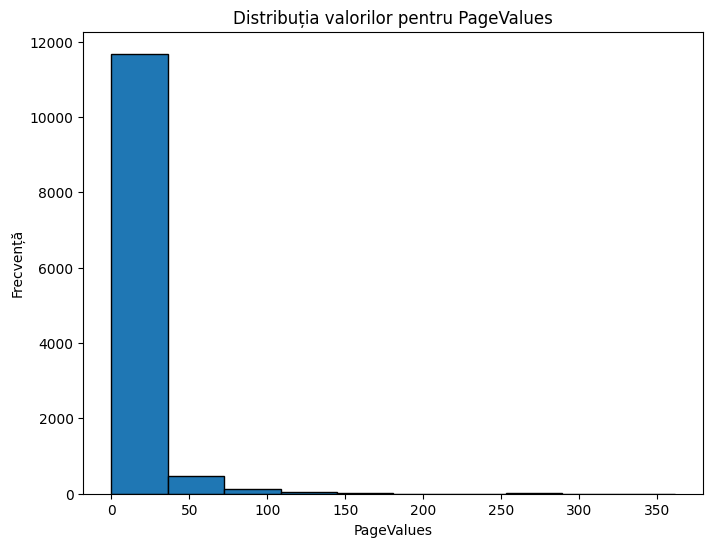

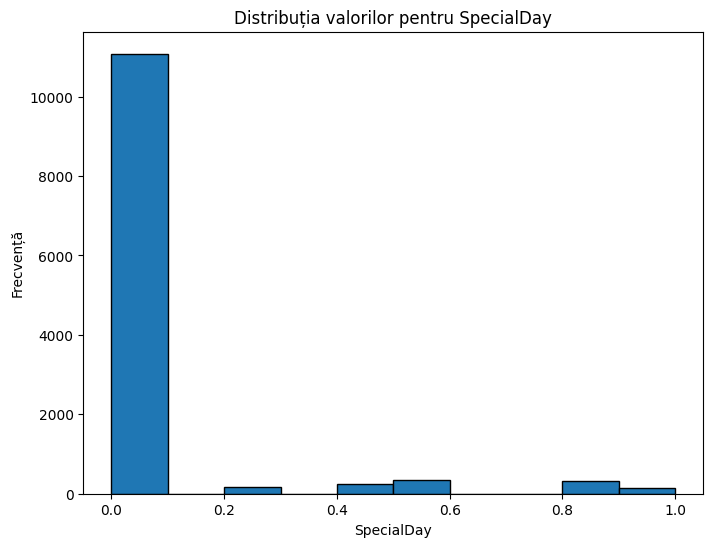

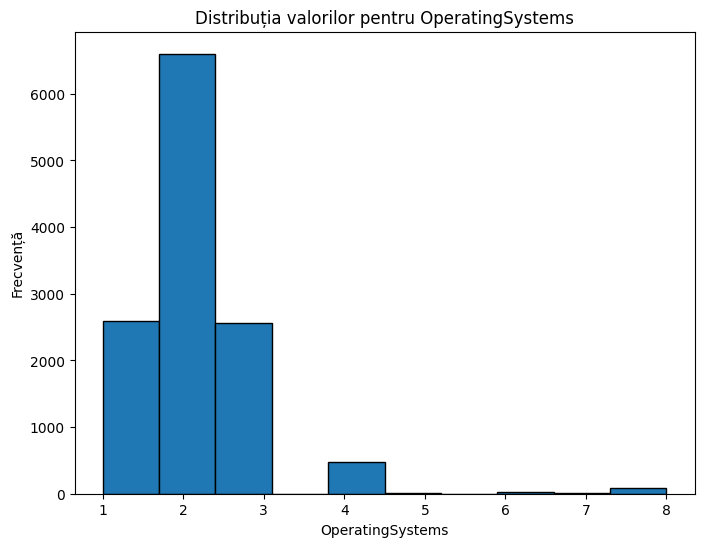

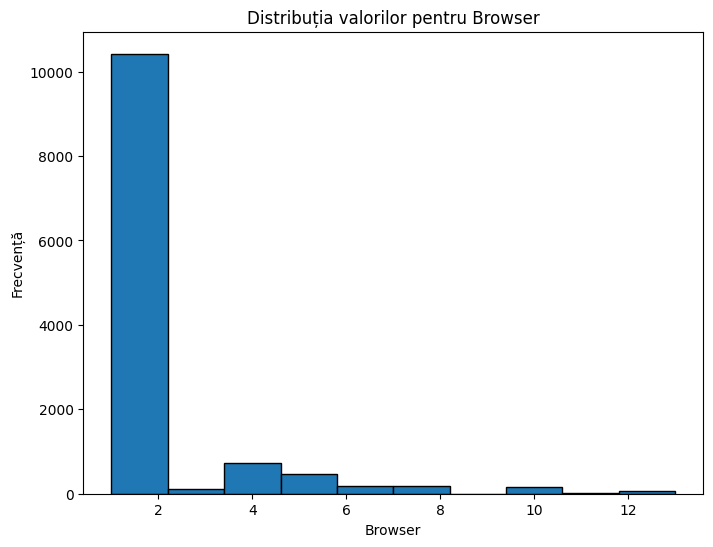

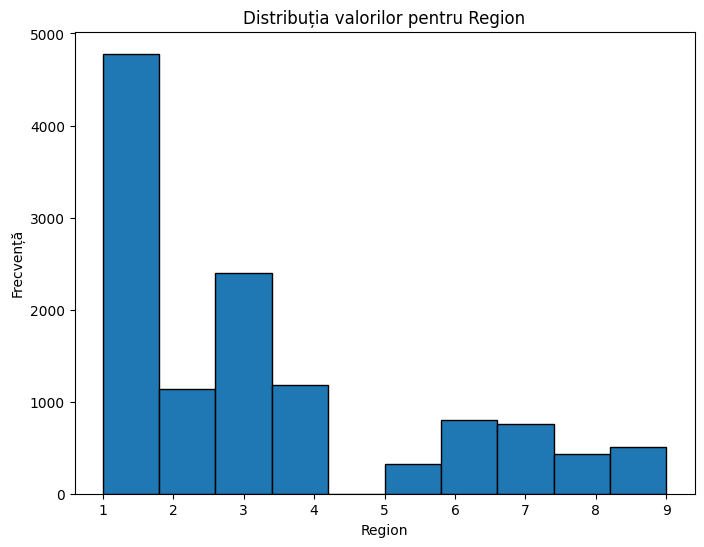

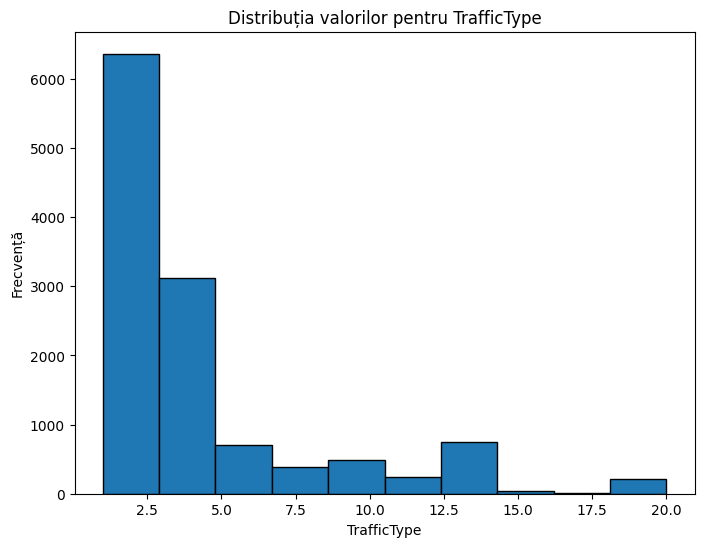

In [13]:
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()

for col in numeric_columns:
    plt.figure(figsize=(8, 6))
    plt.hist(df[col], bins=10, edgecolor='black')
    plt.xlabel(col)
    plt.ylabel('Frecvență')
    plt.title(f'Distribuția valorilor pentru {col}')
    plt.show()


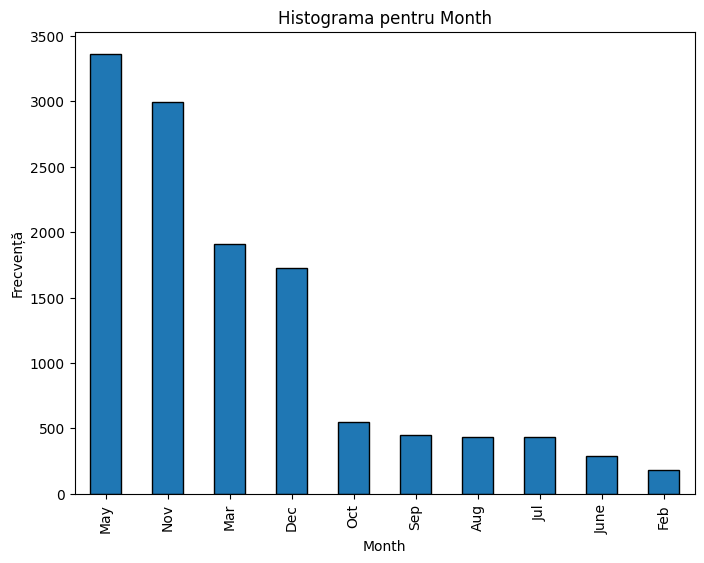

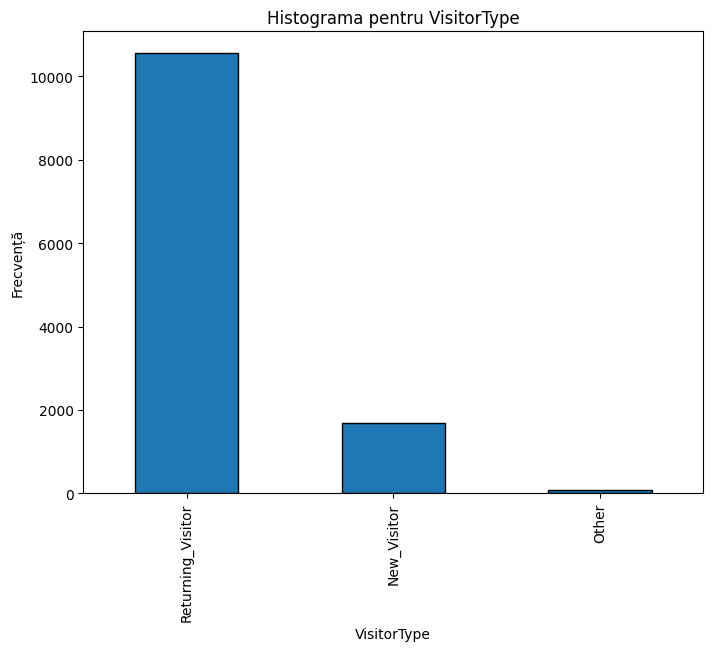

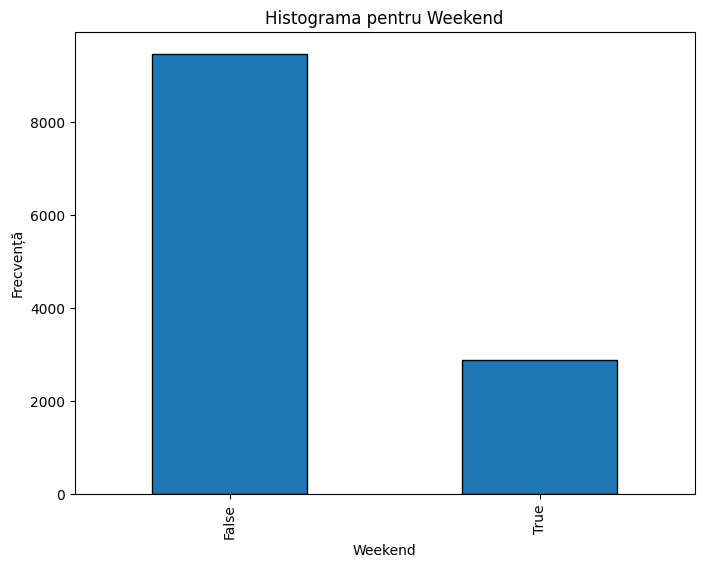

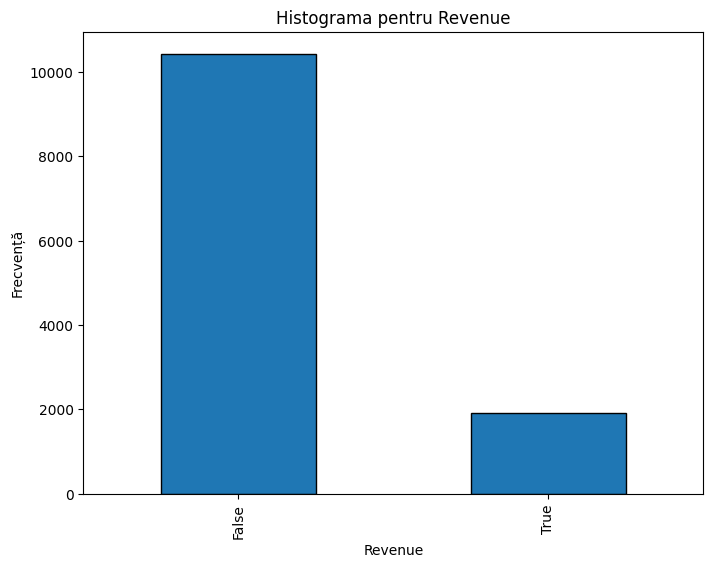

In [12]:
categorical_columns = df.select_dtypes(exclude=np.number).columns.tolist()

for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    df[col].value_counts().plot(kind='bar', edgecolor='black')
    plt.xlabel(col)
    plt.ylabel('Frecvență')
    plt.title(f'Histograma pentru {col}')
    plt.show()

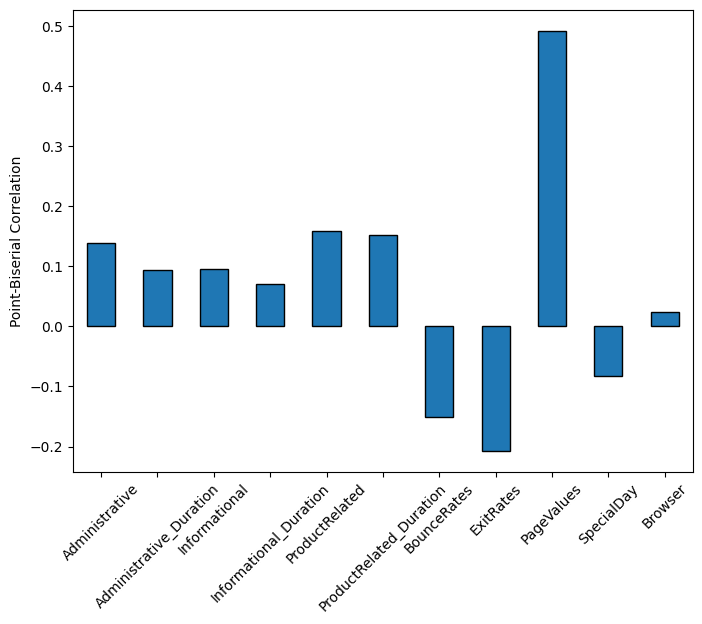

Rezultate:
                         Coefficient        P-Value
Administrative              0.138917   3.519760e-54
Administrative_Duration     0.093587   2.146514e-25
Informational               0.095200   3.174034e-26
Informational_Duration      0.070345   5.282871e-15
ProductRelated              0.158538   3.241187e-70
ProductRelated_Duration     0.152373   6.115338e-65
BounceRates                -0.150673   1.594198e-63
ExitRates                  -0.207071  1.662654e-119
PageValues                  0.492569   0.000000e+00
SpecialDay                 -0.082305   5.498934e-20
OperatingSystems           -0.014668   1.033943e-01
Browser                     0.023984   7.736888e-03
Region                     -0.011595   1.979426e-01
TrafficType                -0.005113   5.702434e-01


In [19]:
numeric_columns = df.select_dtypes(include='number').columns.tolist()
correlation_results = {}

for col in numeric_columns:
    if col != 'Revenue':
        coefficient, p_value = stats.pointbiserialr(df[col], df['Revenue'])
        correlation_results[col] = {'Coefficient': coefficient, 'P-Value': p_value}

correlation_df = pd.DataFrame(correlation_results).T

significant_correlation = correlation_df[correlation_df['P-Value'] <= 0.05]

if not significant_correlation.empty:
    plt.figure(figsize=(8, 6))
    significant_correlation['Coefficient'].plot(kind='bar', edgecolor='black')
    plt.ylabel('Point-Biserial Correlation')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No significant correlation found.")

print("Rezultate:")
print(correlation_df)

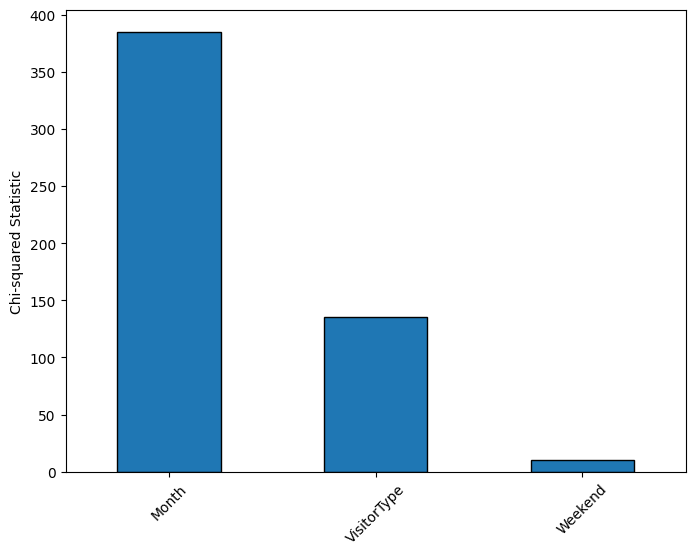

Rezultate:
             Chi2_Statistic       P-Value
Month            384.934762  2.238786e-77
VisitorType      135.251923  4.269904e-30
Weekend           10.390978  1.266325e-03


In [18]:
categorical_columns = df.select_dtypes(exclude='number').columns.tolist()
chi2_results = {}

for col in categorical_columns:
    if col != 'Revenue':
        contingency_table = pd.crosstab(df[col], df['Revenue'])
        chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
        chi2_results[col] = {'Chi2_Statistic': chi2, 'P-Value': p_value}

chi2_df = pd.DataFrame(chi2_results).T

significant_chi2 = chi2_df[chi2_df['P-Value'] <= 0.05]

if not significant_chi2.empty:
    plt.figure(figsize=(8, 6))
    significant_chi2['Chi2_Statistic'].plot(kind='bar', edgecolor='black')
    plt.ylabel('Chi-squared Statistic')
    plt.xticks(rotation=45)
    plt.show()

print("Rezultate:")
print(chi2_df)

In [20]:
def logistic(x):
  return 1 / (1 + np.exp(-x))

def nll(Y, T):
    epsilon = 1e-15  # Fara log(0)
    Y = np.clip(Y, epsilon, 1 - epsilon)
    return -1 * np.sum([t * np.log(Y[idx]) + (1 - t) * np.log(1 - Y[idx]) for idx, t in enumerate(T)])

def accuracy(Y, T):
    Y_bin = []
    for y in Y:
        if y >= 0.5:
            Y_bin.append(1)
        else:
            Y_bin.append(0)

    correct_predictions = 0
    for y_bin, t in zip(Y_bin, T):
        if y_bin == t:
            correct_predictions += 1

    if len(T) != 0:
        acc = correct_predictions / len(T)
    else:
        acc = 0.0

    return acc

def train_logistic(X_train, X_test, T_train, T_test, lr=.01, epochs_no=100):
    (_, D) = X_train.shape
    W = np.random.randn(D)

    test_acc = []

    for _ in range(epochs_no):
        Y_train = list(map(lambda x: logistic(x), np.dot(X_train, W)))

        W -= lr * np.dot(np.transpose(X_train), (Y_train - T_train))

        Y_test = logistic(np.dot(X_test, W))
        test_acc.append(accuracy(Y_test, T_test))

    return W, test_acc


def predict_logistic(X, W):
    return logistic(np.dot(X, W))

In [21]:
df = pd.read_csv("dataset.csv")
label_encoder = LabelEncoder()
for column in df.select_dtypes(exclude='number').columns:
    df[column] = label_encoder.fit_transform(df[column])

X = df.drop('Revenue', axis=1)
T = df['Revenue']


scalers_logistic = {
    'MinMaxScaler': MinMaxScaler(),
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler(),
}

def logistic_regression_manual(scaler, X_train, X_test, T_train, T_test):
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    W_final, test_acc = train_logistic(X_train, X_test, T_train, T_test)

    predictions = predict_logistic(X_test, W_final)
    precision = precision_score(T_test, predictions >= 0.5)
    recall = recall_score(T_test, predictions >= 0.5)
    f1 = f1_score(T_test, predictions >= 0.5)

    return test_acc[-1], precision, recall, f1

def logistic_regression_scikit(scaler, X_train, X_test, T_train, T_test):
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    model_sklearn = LogisticRegression(max_iter=1000)
    model_sklearn.fit(X_train, T_train)
    predictions = model_sklearn.predict(X_test)
    
    acc = accuracy_score(T_test, predictions)
    precision = precision_score(T_test, predictions >= 0.5)
    recall = recall_score(T_test, predictions >= 0.5)
    f1 = f1_score(T_test, predictions >= 0.5)

    return acc, precision, recall, f1

In [23]:
def print_metrics(params, scaler_name, algo_name):
    test_acc, test_precision, test_recall, test_f1 = params
    print(f"{algo_name} : {scaler_name}\n")
    print(f"Accuracy: {test_acc}")
    print(f"Precision: {test_precision}")
    print(f"Recall: {test_recall}")
    print(f"F1-score: {test_f1}")
    print("\n")

X_train, X_test, T_train, T_test = train_test_split(X, T, test_size=0.2)

for scaler_name, scaler in scalers_logistic.items():
    params = logistic_regression_manual(scaler, X_train, X_test, T_train, T_test)
    print_metrics(params, scaler_name, "Manual logistic regression")
    params = logistic_regression_scikit(scaler, X_train, X_test, T_train, T_test)
    print_metrics(params, scaler_name, "Scikit logistic regression")



Manual logistic regression : MinMaxScaler

Accuracy: 0.8746958637469586
Precision: 0.654320987654321
Recall: 0.4140625
F1-score: 0.507177033492823


Scikit logistic regression : MinMaxScaler

Accuracy: 0.8876723438767234
Precision: 0.7559808612440191
Recall: 0.4114583333333333
F1-score: 0.5328836424957841


Manual logistic regression : StandardScaler

Accuracy: 0.7911597729115978
Precision: 0.41136671177266576
Recall: 0.7916666666666666
F1-score: 0.5414069456812111


Scikit logistic regression : StandardScaler

Accuracy: 0.8884833738848338
Precision: 0.7914438502673797
Recall: 0.3854166666666667
F1-score: 0.5183887915936952


Manual logistic regression : RobustScaler

Accuracy: 0.7015409570154095
Precision: 0.32711198428290766
Recall: 0.8671875
F1-score: 0.4750356633380885


Scikit logistic regression : RobustScaler

Accuracy: 0.8913219789132197
Precision: 0.7871287128712872
Recall: 0.4140625
F1-score: 0.5426621160409556




In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
df = pd.read_csv("dataset.csv")
label_encoder = LabelEncoder()
for column in df.select_dtypes(exclude='number').columns:
    df[column] = label_encoder.fit_transform(df[column])

X = df.drop('Revenue', axis=1)
T = df['Revenue']

def decision_tree_scikit( X_train, X_test, T_train, T_test, scaler, depth):
    if scaler:
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        X_train_scaled, X_test_scaled = X_train, X_test

    dtc = DecisionTreeClassifier(max_depth=depth)
    dtc.fit(X_train_scaled, T_train)
    
    predictions = dtc.predict(X_test_scaled)

    test_acc = accuracy_score(T_test, predictions)
    test_precision = precision_score(T_test, predictions)
    test_recall = recall_score(T_test, predictions)
    test_f1 = f1_score(T_test, predictions)

    return test_acc, test_precision, test_recall, test_f1

scalers_tree = {
    'MinMaxScaler': MinMaxScaler(),
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler(),
    'None': None
}

def print_metrics_tree(params, scaler_name, depth):
    test_acc, test_precision, test_recall, test_f1 = params
    print(f"{scaler_name}: depth {depth}")
    print(f"Accuracy: {test_acc}")
    print(f"Precision: {test_precision}")
    print(f"Recall: {test_recall}")
    print(f"F1-score: {test_f1}")
    print("\n")

X_train, X_test, T_train, T_test = train_test_split(X, T, test_size=0.2, random_state=42)
for scaler_name, scaler in scalers_tree.items():
    for depth in range(3, 7):
        params = decision_tree_scikit( X_train, X_test, T_train, T_test, scaler, depth)
        print_metrics_tree(params, scaler_name, depth)

MinMaxScaler: depth 3
Accuracy: 0.8868613138686131
Precision: 0.6774193548387096
Recall: 0.6131386861313869
F1-score: 0.6436781609195402


MinMaxScaler: depth 4
Accuracy: 0.8884833738848338
Precision: 0.7035928143712575
Recall: 0.5717761557177615
F1-score: 0.6308724832214765


MinMaxScaler: depth 5
Accuracy: 0.884022708840227
Precision: 0.7394636015325671
Recall: 0.46958637469586373
F1-score: 0.5744047619047619


MinMaxScaler: depth 6
Accuracy: 0.8864557988645579
Precision: 0.6955223880597015
Recall: 0.5669099756690997
F1-score: 0.6246648793565683


StandardScaler: depth 3
Accuracy: 0.8868613138686131
Precision: 0.6774193548387096
Recall: 0.6131386861313869
F1-score: 0.6436781609195402


StandardScaler: depth 4
Accuracy: 0.8884833738848338
Precision: 0.7035928143712575
Recall: 0.5717761557177615
F1-score: 0.6308724832214765


StandardScaler: depth 5
Accuracy: 0.884022708840227
Precision: 0.7394636015325671
Recall: 0.46958637469586373
F1-score: 0.5744047619047619


StandardScaler: depth

In [24]:
def run_10_times():

    metrics = {'Logistic Manual' : {scaler_name : [[], [], []]  for scaler_name in scalers_tree},
               'Logistic Scikit' : {scaler_name : [[], [], [], []]  for scaler_name in scalers_tree},
               'Decision Tree'  : {scaler_name : {depth : [[], [], []] for depth in range(3,7)} for scaler_name in scalers_tree}}

    for i in range(10):
        X_train, X_test, T_train, T_test = train_test_split(X, T, test_size=0.2)
        
        for scaler_name, scaler in scalers_logistic.items():
            params = logistic_regression_manual(scaler, X_train, X_test, T_train, T_test)
            test_acc, test_precision, test_recall, test_f1 = params
            metrics["Logistic Manual"][scaler_name][0].append(test_precision)
            metrics["Logistic Manual"][scaler_name][1].append(test_recall)
            metrics["Logistic Manual"][scaler_name][2].append(test_f1)

        for scaler_name, scaler in scalers_logistic.items():
            params = logistic_regression_scikit(scaler, X_train, X_test, T_train, T_test)
            test_acc, test_precision, test_recall, test_f1 = params
            metrics["Logistic Scikit"][scaler_name][0].append(test_precision)
            metrics["Logistic Scikit"][scaler_name][1].append(test_recall)
            metrics["Logistic Scikit"][scaler_name][2].append(test_f1)
            metrics["Logistic Scikit"][scaler_name][3].append(test_acc)

        for scaler_name, scaler in scalers_tree.items():
            for depth in range(3, 7):
                params = decision_tree_scikit(X_train, X_test, T_train, T_test, scaler, depth)
                test_acc, test_precision, test_recall, test_f1 = params
                metrics["Decision Tree"][scaler_name][depth][0].append(test_precision)
                metrics["Decision Tree"][scaler_name][depth][1].append(test_recall)
                metrics["Decision Tree"][scaler_name][depth][2].append(test_f1)

    for scaler_name, _ in scalers_logistic.items():
        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"Logistic manual: {scaler_name} : MEAN")
        print(np.mean(metrics["Logistic Manual"][scaler_name][0]))
        print(np.mean(metrics["Logistic Manual"][scaler_name][1]))
        print(np.mean(metrics["Logistic Manual"][scaler_name][2]))

        print(f"Logistic manual: {scaler_name} : VAR")
        print(np.var(metrics["Logistic Manual"][scaler_name][0]))
        print(np.var(metrics["Logistic Manual"][scaler_name][1]))
        print(np.var(metrics["Logistic Manual"][scaler_name][2]))
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"Logistic Scikit: {scaler_name} : MEAN")
        print(np.mean(metrics["Logistic Scikit"][scaler_name][0]))
        print(np.mean(metrics["Logistic Scikit"][scaler_name][1]))
        print(np.mean(metrics["Logistic Scikit"][scaler_name][2]))
        print(np.mean(metrics["Logistic Scikit"][scaler_name][3]))

        print(f"Logistic Scikit: {scaler_name} : VAR")
        print(np.var(metrics["Logistic Scikit"][scaler_name][0]))
        print(np.var(metrics["Logistic Scikit"][scaler_name][1]))
        print(np.var(metrics["Logistic Scikit"][scaler_name][2]))
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

    for scaler_name, _ in scalers_tree.items():
        for depth in range(3,7):
            print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
            print(f"Decision tree: {scaler_name}, {depth} : MEAN")
            print(np.mean(metrics["Decision Tree"][scaler_name][depth][0]))
            print(np.mean(metrics["Decision Tree"][scaler_name][depth][1]))
            print(np.mean(metrics["Decision Tree"][scaler_name][depth][2]))

            print(f"Decision tree: {scaler_name}, {depth} : VAR")
            print(np.var(metrics["Decision Tree"][scaler_name][depth][0]))
            print(np.var(metrics["Decision Tree"][scaler_name][depth][1]))
            print(np.var(metrics["Decision Tree"][scaler_name][depth][2]))
            print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

run_10_times()


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Logistic manual: MinMaxScaler : MEAN
0.7380294613042588
0.30832856456240276
0.225988879355367
Logistic manual: MinMaxScaler : VAR
0.08732548630578944
0.13211842825082948
0.02387328161077367
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Logistic Scikit: MinMaxScaler : MEAN
0.7427360785990588
0.3623024156592788
0.4832182409069989
0.8785482562854824
Logistic Scikit: MinMaxScaler : VAR
0.001045786922961769
0.003193008017878334
0.0020663912422959315
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Logistic manual: StandardScaler : MEAN
0.37246149664744205
0.7556901580489133
0.479796530021138
Logistic manual: StandardScaler : VAR
0.023361368096550105
0.009367835508489589
0.01832628613140692
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Logistic Scikit: StandardScaler : MEAN
0.7570504384642